# Ampliació pràctica 4 PAV 
En aquesta ampliació fem una anàlisis de clustering de locutors mitjançant gmms. Per a avaluar utilitzem el BIC.

In [204]:
#IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = 16, 8

from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA

import sys
import os

import librosa
import librosa.display

In [178]:
#DEFINICIO VARIABLES 
base_path = '/home/jc/pav/practica4'
speecon_path = os.path.join(base_path,'audios','speecon')
temp_path = os.path.join(base_path,'temp')

### Extracció de característiques
Per a realitzar el clustering extreiem els MFCC dels audios.

In [71]:
def lists(speecon):
    ''' Crea listas para calcular los parámetros posteriormente'''
    persons = list()
    
    #Iteramos la base de datos de speecon
    for block in os.listdir(speecon):
        block_path = os.path.join(speecon,block)
        for ses in os.listdir(block_path):
            #Y añadimos el path a la lista
            ses_path = os.path.join(block_path,ses)
            persons.append(ses_path)
            
    return persons

In [72]:
def mfcc_person(folder, n_coefs=12):
    ''' Cálculo de los coeficientes MFCC
        Utiliza la libreria librosa para leer el
        audio y calcular los coeficientes.
        Parametros:
        - n_coefs: int numero de coeficientes para el MFCC
        Devuelve:
        - base: np.array de tamaño Nx12 con los coeficientes para cada trama'''
    
    #Inicializamos un array a ceros
    base = np.zeros((1,12))
    
    #Repasamos fichero a fichero de la carpeta
    for file in os.listdir(folder):
        #Comprobamos que sea audio
        if file.endswith(".wav"):
            
            file_audio = os.path.join(folder, file)
            #print(file_audio)
            
            #Lectura del audio, remuestreamos a 8000Hz
            audio, fs = librosa.core.load(file_audio, sr=8000)
            #Calculo de los coefs
            mfcc_raw = librosa.feature.mfcc(audio, sr=fs, n_mfcc=n_coefs).T
            #Stack de la base de datos con los mfcc calculados
            base = np.vstack((base,mfcc_raw))
            
    print(f'Persona {folder[-3:]} calculada')
    
    return base[1:] #El primero no lo devolvemos porqué es el cero de inializacion
            

In [73]:
def mfcc_list(persons, n_coefs=12):
    ''' Calculo de los mfcc para una lista
        Usamos la funcion mfcc_person para crear los mfcc
        y los exportamos a formato csv. Normalmente lo usamos para 
        todos los ficheros
        Parametros:
        - persons: lista con las carpetas a analizar
        '''
    #Creamos la carpeta para exportar los mfcc
    mfcc_path = os.path.join(temp_path, 'mfcc')
    
    for person in persons:
        #Cálculo de los mfcc
        mfcc = mfcc_person(folder=person, n_coefs=n_coefs)
        #Exportamos fichero
        person_path = os.path.join(mfcc_path, person[-3:]+'.mfcc')

        np.savetxt(person_path, mfcc, delimiter=",")
    
    return 

In [ ]:
lists = lists(speecon_path)

In [ ]:
mfcc_list(lists)

### Selecció d'audios
Per a realitzar els experiments no utilitzem tots els audios sinó una selecció

In [117]:
def read_mfcc(person, count):
    ''' Reads mfcc file from person
        Parametros:
        - person: string persona de la que leeremos los coeficientes
    '''
    person_path = os.path.join(temp_path, 'mfcc', f'{person}.mfcc')
    mfcc = np.loadtxt(person_path, delimiter=',')
    
    mat = np.zeros((mfcc.shape[0],mfcc.shape[1]+1)) + count
    mat[:,:-1] = mfcc
    
    return mat

In [118]:
def read_mfcc_list(list_mfcc):
    ''' Lectura dels mfcc d'una llista
    '''
    base = np.zeros((1,13))
    i = 0
    for mfcc in list_mfcc:
        mfcc_coef = read_mfcc(mfcc,i)
        i = i+1
        base = np.vstack((base,mfcc_coef))
    
    return base[1:,:]

In [314]:
read_list = ['001', '087', '259', '085', '004', '105']
db = read_mfcc_list(read_list)

### PCA dels MFCC

In [287]:
def make_pca(person):
    pca = PCA(n_components=2)
    pca.fit(person.T)
    return pca.components_

In [296]:
pca_list = list()
pc = make_pca(reduced_db)

In [298]:
pc = np.vstack((db[:,-1], pc))

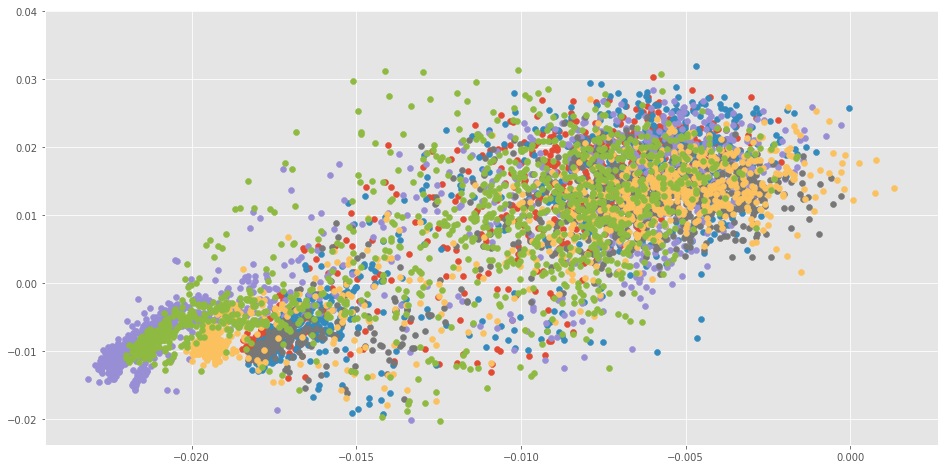

In [325]:
for i in range(0,len(read_list)+1):
    plot = pc[1:,pc[0,:] == i]
    plt.scatter(plot[0],plot[1])

### Càlcul de les GMM i mètriques d'evaluació
Per a calcular les GMM utilitzem la llibreria scikit learn que té una implementació fet i també el càlcul de mètriques per a l'evaluació

In [171]:
def SelBest(arr:list, X:int)->list:
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [196]:
n_clusters=np.arange(2, 12)
bics=[]
bics_err=[]
aics=[]
aics_err=[]
iterations=20
for n in n_clusters:
    tmp_bic=[]
    tmp_aic=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(db[:,:-1]) 
        tmp_bic.append(gmm.bic(db[:,:-1]))
        tmp_aic.append(gmm.aic(db[:,:-1]))
        
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)
    
    val=np.mean(SelBest(np.array(tmp_aic), int(iterations/5)))
    err=np.std(tmp_aic)
    aics.append(val)
    aics_err.append(err)

### Anàlisis del nombre òptim de clusters
Per a trobar el nombre òptim de clusters realitzem plots de les mètriques d'evaluació i busquem un punt on sembli bon resultat. Com més baixa puntuació millor.

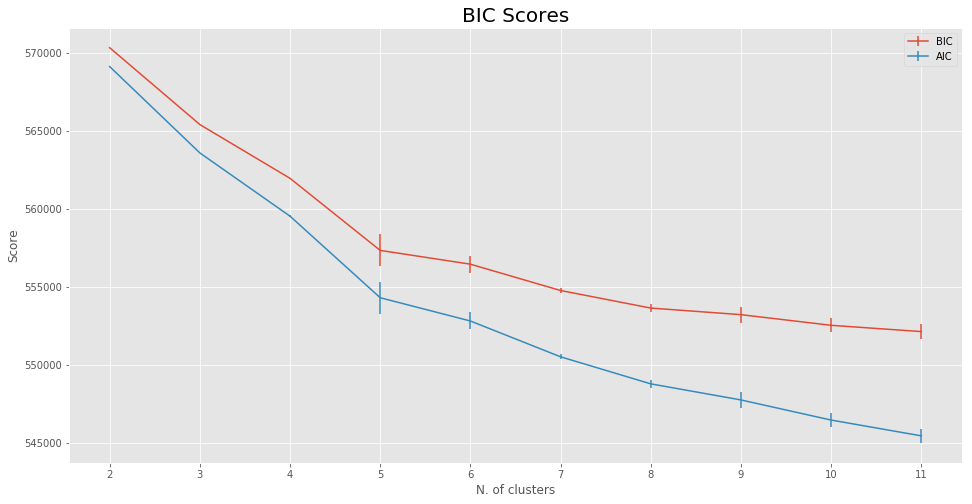

In [205]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.errorbar(n_clusters,aics, yerr=aics_err, label='AIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

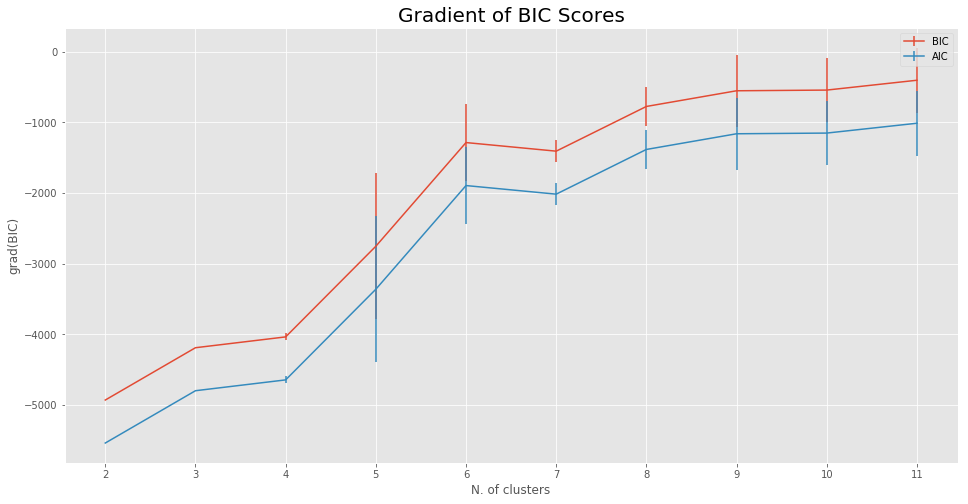

In [206]:
plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
plt.errorbar(n_clusters, np.gradient(aics), yerr=bics_err, label='AIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

In [200]:
from sklearn import metrics 
n_clusters=np.arange(2, 12)
sils=[]
sils_err=[]
iterations=10
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(db[:,:-1]) 
        labels=gmm.predict(db[:,:-1])
        sil=metrics.silhouette_score(db[:,:-1], labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

Text(0, 0.5, 'Score')

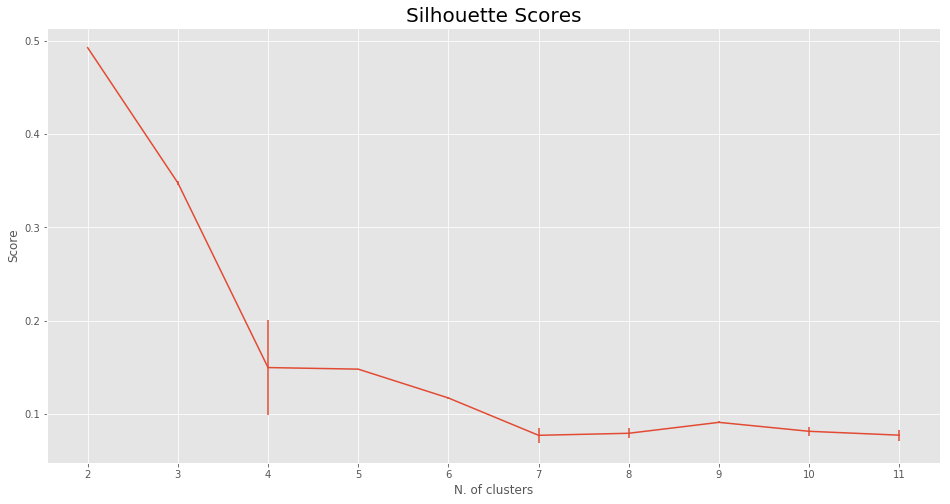

In [207]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

### Anàlisis dels clusters
Un cop hem escollit el nombre òptim de clusters realitzem l'aplicació de la GMM i calculem varies mètriques per a veure si els resultats són bons

In [ ]:
def make_pca(person):
    pca = PCA(n_components=2)
    pca.fit(person.T)
    return pca.components_

In [179]:
#KMEANS
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(db[:,:-1])
a = kmeans.labels_
c = a.reshape(a.shape[0],1)
db = np.hstack((db,c))
#TODO: TREURE STATS DELS CLUSTERS
(db[-1] == db[-2]).sum()

3

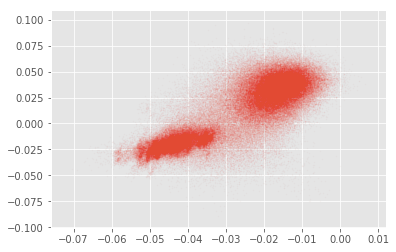

In [19]:
plt.scatter(big[0],big[1],s=1, alpha=0.02)

In [1]:
#EXTRACCIÓ FEATURES AUDIOS

In [ ]:
#CÀLCUL DE LES GMMS

In [ ]:
#AVALUACIÓ DELS RESULTATS